# Lecture 4: Text and High-Dimensional Learning

Machine learning in high dimensions can be challenging, most notably because of the risk of overfitting.  Many of the datasets we work with in this class are already "vectorized", or set up so that the features are represented in vectors (aka rows in a matrix), but in this example we'll use text data.  Text data has to be explicitly vectorized, and when you vectorize it, it tends to be extremely high-dimensional because each word becomes a feature in the vector and there are usually hundreds or thousands of possible words in a corpus (a "corpus" is a body of many documents).

In [99]:
%matplotlib inline

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

The "20 Newsgroups" dataset is a corpus of documents that are classified by topic; there are 20 topics (read more about them [here](http://qwone.com/~jason/20Newsgroups/)) but we will just pull out two topics and build a classifier to discriminate between them.

In [65]:
data = sklearn.datasets.fetch_20newsgroups(
    categories = [
    'alt.atheism',
    'talk.religion.misc'], subset='train')

In [9]:
len(data.data)  # how many documents are there

857

In [5]:
data.target_names # quick check: what labels are present

['alt.atheism', 'talk.religion.misc']

In [14]:
data.data[100] # let's look at a random document

"From: kv07@IASTATE.EDU (Warren Vonroeschlaub)\nSubject: Re: Albert Sabin\nReply-To: kv07@IASTATE.EDU (Warren Vonroeschlaub)\nOrganization: Ministry of Silly Walks\nLines: 30\n\nIn article <1993Apr15.225657.17804@rambo.atlanta.dg.com>, wpr@atlanta.dg.com\n(Bill Rawlins) writes:\n>       Since you have referred to the Messiah, I assume you are referring\n>        to the New Testament.  Please detail your complaints or e-mail if\n>        you don't want to post.  First-century Greek is well-known and\n>        well-understood.  Have you considered Josephus, the Jewish Historian,\n>        who also wrote of Jesus?  In addition, the four gospel accounts\n>        are very much in harmony.  \n\n  Bill, I find it rather remarkable that you managed to zero in on what is\nprobably the weakest evidence.\n\n  What is probably the most convincing is the anti-Christian literature put out\nby the Jewish councils in the second century.  There are enormous quantities of\ndetailed arguments against Ch

In [66]:
data.target[100]  # and what was the corresponding label?

1

Check the class balance.  A quick way to do this with binary problems, where all the target labels are encoded as 0 or 1, is to take the average of the list of the targets.  We're rounding the result for readability, otherwise it often stretches out for many digits.

In [67]:
round(sum(data.target)/len(data.target),3)

0.44

The dataset is 44% zeroes (articles on atheism) and 56% ones (articles on religion). Probably not a situation where we have to worry about imbalanced learning.

## Vectorization and learning

Scikit-learn has a number of modules specialized for learning on text data.  A full treatment of text learning is beyond the scope of this course, but we'll use some of the most common tools.

First up is `CountVectorizer()`, which is also commonly called a bag-of-words representation.  The vectorizer learns one feature for each word in the total vocabulary of the corpus and then one-hot encodes each document so that you get a matrix of `n_words` width by `n_documents` length.

The `CountVectorizer()` we see here is a special type of scikit-learn object called a transformer.  Transformers are meant to change the representation of data, but do not themselves generally do "machine learning" proper.  Examples of transformers include PCA, SelectKBest, and CountVectorizer.  Besides transformers, the other main type of scikit-learn object is the estimator, which is a class of objects that includes most familiar supervised learning algorithms like LogisticRegression, DecisionTreeClassifier, and SVC (support vector classifier).

In [68]:
bag_of_words = CountVectorizer()
vect_data = bag_of_words.fit_transform(data.data)

In [24]:
len(list(bag_of_words.vocabulary_.keys()))  # how big is the vocabulary?

18089

In [92]:
print(vect_data[100].toarray()) # can we see the words for document 100?

[[ 0.  0.  0. ...,  0.  0.  0.]]


In [61]:
clf = LogisticRegression(C=1e5)  # build a logistic regression with regularization turned off

In general, it's best to do proper cross-validation using scikit-learn's [KFold()](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class, but as a shortcut during development I often use [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) as a shortcut.  This function takes your estimator (in this case, the `LogisticRegression` object), the training data, and optionally parameters for the number of folds and the [scoring function](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [73]:
print(cross_val_score(clf, vect_data, data.target, scoring='roc_auc'))

[ 0.97058532  0.9734127   0.96405   ]


In [74]:
clf.fit(vect_data, data.target)
len(clf.coef_[0]) # once we've fit the classifier, we can get the coefficients back

18089

In [64]:
clf.coef_[0][:10]  # and we can inspect the values of some coefficients

array([ 0.05742861, -0.27298711, -0.00440943,  0.00417554, -0.00241909,
       -0.0048393 ,  0.00209659, -0.21381893, -0.08680643, -0.00457778])

Now we'll turn on the regularization in `LogisticRegression` by turning the C value (which is inversely related to the regularization strength) to a lower value.  As it turns out, we already had a pretty good model and this won't help us out, but it's good to see the effect on the coefficients of the model (they get smaller).

In [96]:
clf2 = LogisticRegression(C=0.001)
print(cross_val_score(clf2, vect_data, data.target, scoring='roc_auc'))

[ 0.87331349  0.88050595  0.8741    ]


In [76]:
clf2.fit(vect_data, data.target)
len(clf2.coef_[0])

18089

In [77]:
clf2.coef_[0][:10]  #smaller coefficients than before

array([ 0.00106547, -0.00608696,  0.0005937 ,  0.00035632, -0.00020432,
       -0.00037431,  0.0002758 , -0.00122118, -0.00127799, -0.00025323])

A second way to vectorize the text is using a [TF-IDF transformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).  Where the CountVectorizer simply counted up the number of times each word occurs in each document, a TF-IDF vectorizer weights each word by the term frequency (TF), aka how often each word occurs in a given document, and by the inverse document frequency (IDF), aka how rarely each word occurs in the corpus as a whole.  The goal is to up-weight words that are rare, because they probably are more indicative of interesting content than more common words.

In [94]:
tf_idf = TfidfVectorizer()
vect_data = tf_idf.fit_transform(data.data)

In [95]:
len(list(tf_idf.vocabulary_.keys()))  # same size of vocabulary

18089

In [98]:
clf3 = LogisticRegression(C=1e5)
print(cross_val_score(clf3, vect_data, data.target, scoring='roc_auc'))

[ 0.98303571  0.98546627  0.9792    ]


Interesting.  It looks like our un-regularized classifier is doing a *bit* better with the TF-IDF representation.  To know for sure, we would probably want to run each one several hundred times and histogram the ROC AUC values, to smooth out any noise.

# Visualizing the coeffients as the regularization changes

Last, we'll look at several different values of the regularization parameter C, and how the logistic regression coefficients change.

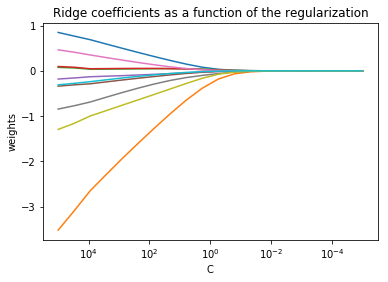

In [116]:
n_alphas = 20
alphas = np.logspace(-5, 5, n_alphas)

coefs = []
for c in alphas:
    clf = LogisticRegression(C=c, penalty='l2')
    clf.fit(vect_data, data.target)
    coefs.append(clf.coef_[0][:10])
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('C')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()